In [7]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
from imblearn.under_sampling import RandomUnderSampler

In [8]:
UNPROCESSED_DATASETS_PATH = 'unprocessed_datasets'
PROCESSED_DATASETS_PATH = 'processed_datasets'
SAMPLE_SIZE = len([name for name in os.listdir(UNPROCESSED_DATASETS_PATH) if os.path.isdir(os.path.join(UNPROCESSED_DATASETS_PATH, name))])

In [ ]:
EXERCICES_TYPE = []
SENSORS_TYPE = []

for root, dirs, files in os.walk(UNPROCESSED_DATASETS_PATH):
    for dir_name in dirs:
        if not dir_name.isdigit() and dir_name not in EXERCICES_TYPE:
            EXERCICES_TYPE.append(dir_name)          

    for file_name in files:
        if file_name.split('_')[0] not in SENSORS_TYPE:
            SENSORS_TYPE.append(file_name.split('_')[0])

print("\nEXERCICES_TYPE :")
print(EXERCICES_TYPE)

print("\nSENSORS_TYPE :")
print(SENSORS_TYPE)

In [ ]:
def save_to_csv(df, output_dir):
        os.makedirs(os.path.dirname(output_dir), exist_ok=True)
        df.to_csv(output_dir, index=False)

def process_data(input_file):
        data = pd.read_csv(input_file)
        non_numeric_keys = [key for key in data.keys() if not (isinstance(key, (int, float)) or key.isdigit())]
        data = data.rename(columns={non_numeric_keys[0]: 'ID'})
        data = data.set_index('ID').transpose()
        return data

def existing_directory(output_dir):
    if os.path.exists(output_dir):
        print(f"File {output_dir} already exists")
        return True
    return False

In [16]:
for exercice in EXERCICES_TYPE:
    for sensor in SENSORS_TYPE:
        output_dir = f"{PROCESSED_DATASETS_PATH}/unbalanced/{exercice}/{sensor}.csv"
        if existing_directory(output_dir):
            continue
        df = pd.DataFrame()
        for i in range(1, SAMPLE_SIZE):
            try:
                input_file = f'{UNPROCESSED_DATASETS_PATH}/{i}/{exercice}/{sensor}_1.csv'
                print(f'Reading {input_file}')
                
                processed_data = process_data(input_file)
                df = pd.concat([df, processed_data], axis=0).reset_index(drop=True)
            except Exception as e:
                print(f"Error processing file {input_file}: {e}")
                continue
            
        print(f"Saving {exercice} to {output_dir}")
        save_to_csv(df, output_dir)


Reading unprocessed_datasets/4/back/emg_1.csv
Reading unprocessed_datasets/5/back/emg_1.csv
Reading unprocessed_datasets/6/back/emg_1.csv
Reading unprocessed_datasets/7/back/emg_1.csv
Reading unprocessed_datasets/8/back/emg_1.csv
Reading unprocessed_datasets/9/back/emg_1.csv
Reading unprocessed_datasets/10/back/emg_1.csv
Reading unprocessed_datasets/11/back/emg_1.csv
Reading unprocessed_datasets/12/back/emg_1.csv
Reading unprocessed_datasets/13/back/emg_1.csv
Reading unprocessed_datasets/14/back/emg_1.csv
Reading unprocessed_datasets/15/back/emg_1.csv
Reading unprocessed_datasets/16/back/emg_1.csv
Reading unprocessed_datasets/17/back/emg_1.csv
Reading unprocessed_datasets/18/back/emg_1.csv
Reading unprocessed_datasets/19/back/emg_1.csv
Reading unprocessed_datasets/20/back/emg_1.csv
Reading unprocessed_datasets/21/back/emg_1.csv
Reading unprocessed_datasets/22/back/emg_1.csv
Error processing file unprocessed_datasets/22/back/emg_1.csv: [Errno 2] No such file or directory: 'unprocessed_d

In [17]:
number_of_measures = pd.DataFrame(columns=SENSORS_TYPE, index=EXERCICES_TYPE)
for exercice in EXERCICES_TYPE:
    for sensor in SENSORS_TYPE:
        number_of_measures.loc[exercice, sensor] = pd.read_csv(f"{PROCESSED_DATASETS_PATH}/unbalanced/{exercice}/{sensor}.csv").shape[0]

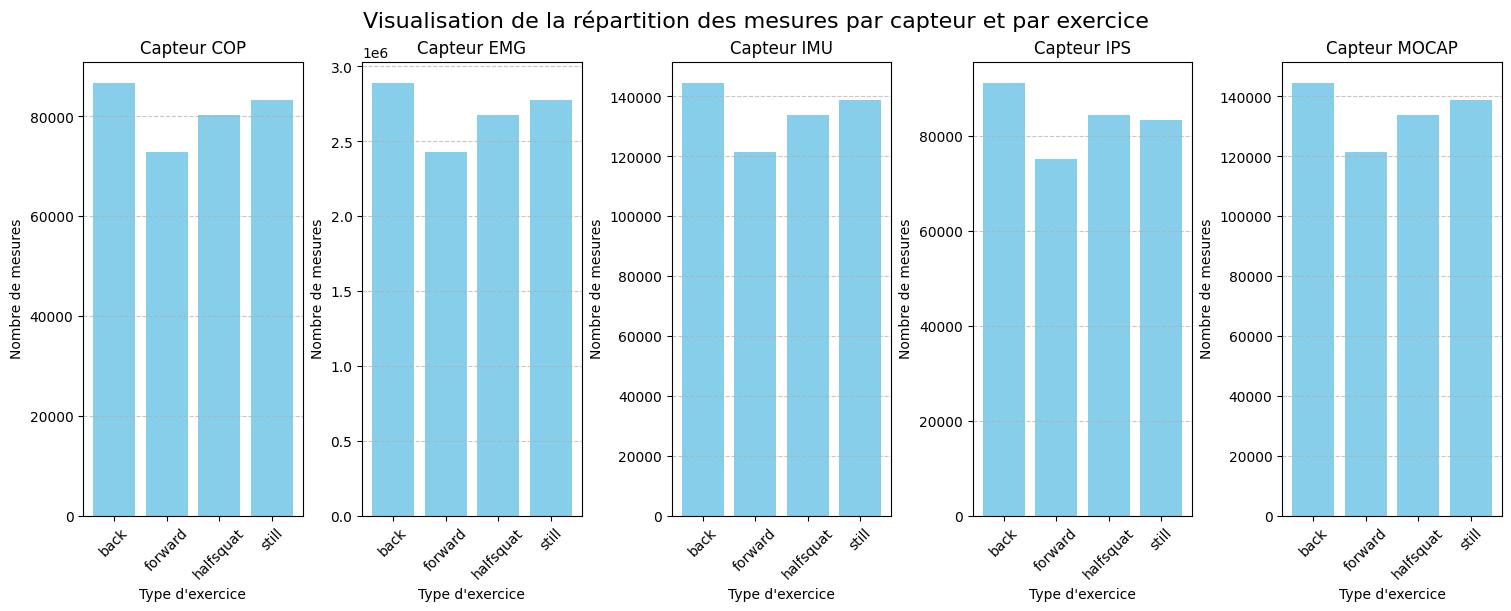

In [18]:
# Paramètres pour définir le nombre de colonnes en fonction du nombre de capteurs
num_sensors = len(SENSORS_TYPE)
fig, axs = plt.subplots(1, num_sensors, figsize=(15, 6), constrained_layout=True)

for i, sensor in enumerate(SENSORS_TYPE):
    # Visualisation de la répartition des classes pour chaque capteur
    axs[i].bar(EXERCICES_TYPE, number_of_measures[sensor], color='skyblue')
    axs[i].set_xlabel("Type d'exercice")
    axs[i].set_ylabel("Nombre de mesures")
    axs[i].set_title(f"Capteur {sensor.upper()}", fontsize=12)
    axs[i].tick_params(axis='x', rotation=45)  # Rotation des labels de l'axe x pour plus de lisibilité
    axs[i].grid(axis='y', linestyle='--', alpha=0.7)  # Ajout d'une grille sur l'axe y

# Titre global pour la figure
fig.suptitle("Visualisation de la répartition des mesures par capteur et par exercice", fontsize=16)
plt.show()

In [19]:
rus = RandomUnderSampler(random_state=42)

for sensor in SENSORS_TYPE:
    combined_df = pd.DataFrame()
    for exercice in EXERCICES_TYPE:
        output_dir = f"{PROCESSED_DATASETS_PATH}/balanced/{exercice}/{sensor}.csv"
        if existing_directory(output_dir):
            continue 
        print(f"Reading {exercice}/{sensor}.csv")
        df = pd.read_csv(f"{PROCESSED_DATASETS_PATH}/unbalanced/{exercice}/{sensor}.csv")  # Replace with the actual path
        df['label'] = exercice
        # Combine the datasets
        combined_df = pd.concat([df, combined_df], ignore_index=True)
    
    if existing_directory(output_dir) == False:
        combined_df.dropna(inplace=True)
        # Separate features and labels
        X = combined_df.drop(columns=['label'])  # Features
        y = combined_df['label']  # Labels

        X_resampled, y_resampled = rus.fit_resample(X, y)

        # Apply UnderSampler to balance the classes
        print(f"Applying UnderSampler to {sensor}.csv")
        print(X.shape, y.shape)
        X_resampled, y_resampled = rus.fit_resample(X, y)
        print(f"Applied")
        print(X_resampled.shape, y_resampled.shape)

        # Combine the resampled features and labels into a new DataFrame
        balanced_df = pd.DataFrame(X_resampled, columns=X.columns)
        balanced_df['label'] = y_resampled

        for exercice_type in EXERCICES_TYPE:
            output_dir = f"{PROCESSED_DATASETS_PATH}/balanced/{exercice_type}/{sensor}.csv"
            save_to_csv(balanced_df[balanced_df['label'] == exercice_type], output_dir)
            print(f"Saved {exercice_type} to {sensor}.csv")

Reading back/cop.csv
Reading forward/cop.csv
Reading halfsquat/cop.csv
Reading still/cop.csv
Applying UnderSampler to cop.csv
(314942, 10) (314942,)
Applied
(288476, 10) (288476,)
Saved back to cop.csv
Saved forward to cop.csv
Saved halfsquat to cop.csv
Saved still to cop.csv
Reading back/emg.csv
Reading forward/emg.csv
Reading halfsquat/emg.csv
Reading still/emg.csv
Applying UnderSampler to emg.csv
(10772128, 16) (10772128,)
Applied
(9712004, 16) (9712004,)
Saved back to emg.csv
Saved forward to emg.csv
Saved halfsquat to emg.csv
Saved still to emg.csv
Reading back/imu.csv
Reading forward/imu.csv
Reading halfsquat/imu.csv
Reading still/imu.csv
Applying UnderSampler to imu.csv
(538613, 54) (538613,)
Applied
(485604, 54) (485604,)
Saved back to imu.csv
Saved forward to imu.csv
Saved halfsquat to imu.csv
Saved still to imu.csv
Reading back/ips.csv
Reading forward/ips.csv
Reading halfsquat/ips.csv
Reading still/ips.csv
Applying UnderSampler to ips.csv
(333874, 682) (333874,)
Applied
(3001

C:\Users\floda\AppData\Local\Temp\ipykernel_10704\2970153407.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  balanced_df['label'] = y_resampled


Saved back to ips.csv
Saved forward to ips.csv
Saved halfsquat to ips.csv
Saved still to ips.csv
Reading back/mocap.csv
Reading forward/mocap.csv
Reading halfsquat/mocap.csv
Reading still/mocap.csv
Applying UnderSampler to mocap.csv
(538613, 78) (538613,)
Applied
(485604, 78) (485604,)
Saved back to mocap.csv
Saved forward to mocap.csv
Saved halfsquat to mocap.csv
Saved still to mocap.csv


In [20]:
number_of_measures = pd.DataFrame(columns=SENSORS_TYPE, index=EXERCICES_TYPE)
for exercice in EXERCICES_TYPE:
    for sensor in SENSORS_TYPE:
        number_of_measures.loc[exercice, sensor] = pd.read_csv(f"{PROCESSED_DATASETS_PATH}/balanced/{exercice}/{sensor}.csv").shape[0]

In [21]:
for sensor in SENSORS_TYPE:
    output_dir = f"{PROCESSED_DATASETS_PATH}/balanced/combined/{sensor}.csv"
    if existing_directory(output_dir) == False:
        combined_df = pd.DataFrame()
        for exercice in EXERCICES_TYPE: 
            print(f"Reading {exercice}/{sensor}.csv")
            df = pd.read_csv(f"{PROCESSED_DATASETS_PATH}/unbalanced/{exercice}/{sensor}.csv")  # Replace with the actual path
            df['label'] = exercice
            # Combine the datasets
            combined_df = pd.concat([df, combined_df], ignore_index=True)
        print(combined_df.head())
        save_to_csv(combined_df, output_dir)


Reading back/cop.csv
Reading forward/cop.csv
Reading halfsquat/cop.csv
Reading still/cop.csv
      L_force     R_force   L_cop_x   L_cop_y   R_cop_x   R_cop_y  L_cop_col  \
0  379.888230  382.717709 -0.034578  0.208298 -0.024375 -0.118024       6.92   
1  381.004205  382.717709 -0.034726  0.208249 -0.024538 -0.117956       6.91   
2  380.736195  382.717709 -0.034947  0.208284 -0.024698 -0.117885       6.92   
3  381.584160  381.821414 -0.035432  0.207988 -0.024785 -0.117850       6.93   
4  380.450611  381.821414 -0.035850  0.207939 -0.024996 -0.117710       6.95   

   L_cop_row  R_cop_col  R_cop_row  label  
0      16.66       6.87      15.31  still  
1      16.68       6.88      15.33  still  
2      16.73       6.88      15.35  still  
3      16.77       6.88      15.36  still  
4      16.85       6.88      15.39  still  
Reading back/emg.csv
Reading forward/emg.csv
Reading halfsquat/emg.csv
Reading still/emg.csv
     R_Vlat      R_RF      R_ST      R_TA    L_Vlat      L_RF      L_

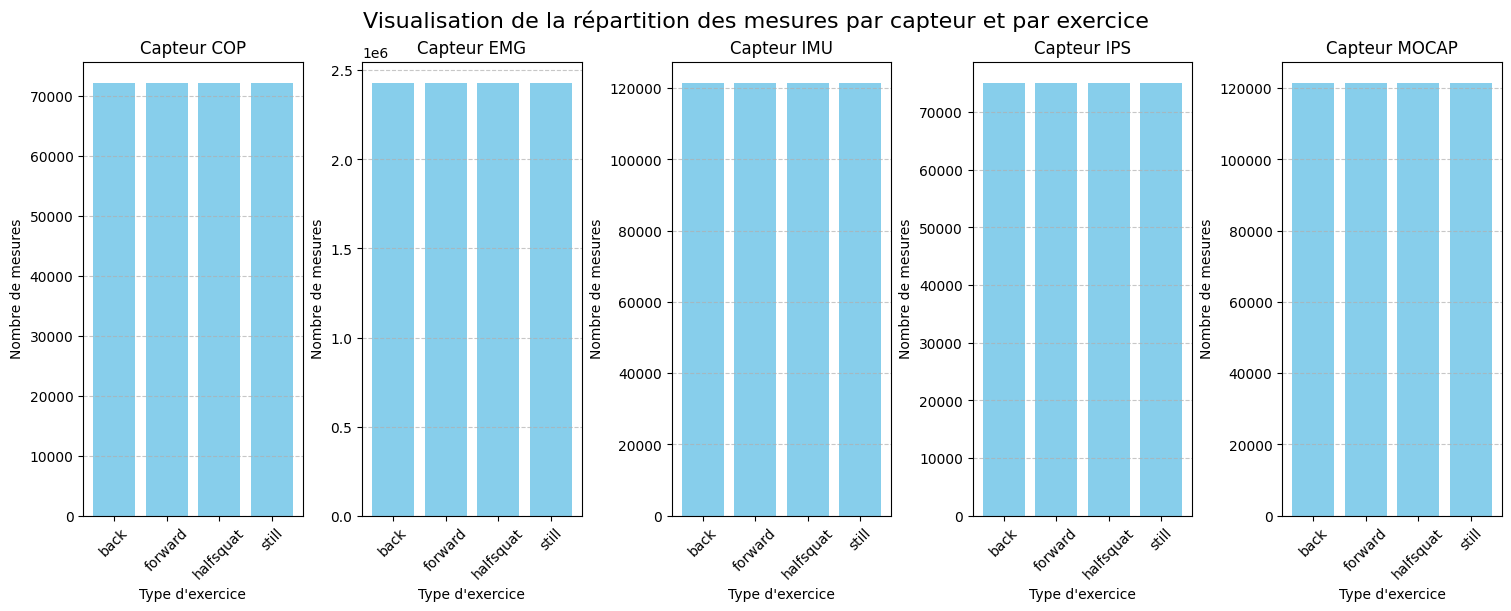

In [22]:
# Paramètres pour définir le nombre de colonnes en fonction du nombre de capteurs
num_sensors = len(SENSORS_TYPE)
fig, axs = plt.subplots(1, num_sensors, figsize=(15, 6), constrained_layout=True)

for i, sensor in enumerate(SENSORS_TYPE):
    # Visualisation de la répartition des classes pour chaque capteur
    axs[i].bar(EXERCICES_TYPE, number_of_measures[sensor], color='skyblue')
    axs[i].set_xlabel("Type d'exercice")
    axs[i].set_ylabel("Nombre de mesures")
    axs[i].set_title(f"Capteur {sensor.upper()}", fontsize=12)
    axs[i].tick_params(axis='x', rotation=45)  # Rotation des labels de l'axe x pour plus de lisibilité
    axs[i].grid(axis='y', linestyle='--', alpha=0.7)  # Ajout d'une grille sur l'axe y

# Titre global pour la figure
fig.suptitle("Visualisation de la répartition des mesures par capteur et par exercice", fontsize=16)
plt.show()

In [117]:
emg_df = pd.read_csv(f"{PROCESSED_DATASETS_PATH}/unbalanced/back/EMG.csv")

In [234]:
def resampling(current_frequency,desired_frequency,data_path):
    df = pd.read_csv(data_path)
    n_points = df.shape[0] 
    current_period = (1/current_frequency)
    desired_period = (1/desired_frequency)

    current_period = round(current_period,5)
    desired_period = round(desired_period,5)

    print(current_period)
    print(desired_period)

    time = pd.date_range(start='00:00:00', periods=n_points, freq=f'{current_period}s')
    df['time'] = time
    # Supposons que 'time' soit déjà un index de type datetime
    df.set_index('time', inplace=True)

    # On resample à 100 Hz (en prenant la moyenne des segments)
    df_downsampled = df.resample(f'{desired_period}s').mean()
    if(current_period>desired_period):
        print("Fréquence d'échantillonnage plus petite que 100Hz\n")
        print("Création de nouvelle données\n")
        df_downsampled.interpolate(method='linear', inplace=True)
    # Réinitialisez l'index si nécessaire
    df_downsampled.reset_index(inplace=True)
    return df_downsampled
    

In [ ]:
df_ips=resampling(60,100,f"{PROCESSED_DATASETS_PATH}/unbalanced/back/ips.csv")

0.01667
0.05


In [240]:
df_ips.tail(),df_ips.shape

(                         time    0    1    2    3    4    5    6    7    8  \
 30359 2024-11-16 00:25:17.950  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
 30360 2024-11-16 00:25:18.000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
 30361 2024-11-16 00:25:18.050  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
 30362 2024-11-16 00:25:18.100  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
 30363 2024-11-16 00:25:18.150  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
 
        ...  672  673  674  675  676    677        678        679  680  681  
 30359  ...  0.0  0.0  0.0  0.0  0.0  13.69  11.363333  12.463333  0.0  0.0  
 30360  ...  0.0  0.0  0.0  0.0  0.0  13.69  11.110000  12.330000  0.0  0.0  
 30361  ...  0.0  0.0  0.0  0.0  0.0  13.56  11.110000  12.330000  0.0  0.0  
 30362  ...  0.0  0.0  0.0  0.0  0.0  13.69  11.110000  12.330000  0.0  0.0  
 30363  ...  0.0  0.0  0.0  0.0  0.0  13.69  11.110000  12.330000  0.0  0.0  
 
 [5 rows x 683 columns],
 (30364, 683))

In [ ]:
df_emg=resampling(2000,100,f"{PROCESSED_DATASETS_PATH}/unbalanced/back/emg.csv")

0.0005
0.05


In [242]:
df_emg.tail(),df_emg.shape

(                         time    R_Vlat       R_RF       R_ST       R_TA  \
 28885 2024-11-16 00:24:04.250 -0.010973  -1.946686  -2.297993 -20.784119   
 28886 2024-11-16 00:24:04.300 -0.979025  -0.528881  -3.519745  -4.125000   
 28887 2024-11-16 00:24:04.350  2.200278  -3.331421  -3.712354   6.420135   
 28888 2024-11-16 00:24:04.400  1.092682  -2.586182  -3.884808 -14.128326   
 28889 2024-11-16 00:24:04.450 -8.560181 -17.623901 -11.984253  34.542847   
 
          L_Vlat      L_RF      L_ST       L_TA      R_MG      R_LG      R_SOL  \
 28885 -2.553955 -2.502226 -1.721100   7.841125 -5.204590  0.664662  -0.857025   
 28886 -0.814728 -2.627294 -1.800659  13.570404 -1.104767 -0.734161  -0.635838   
 28887 -0.934570 -3.838989 -2.006250 -19.174805 -4.539917  0.482391  -1.927551   
 28888 -1.063783  0.543823 -2.600502  -9.357788 -4.103007 -0.894287   1.167206   
 28889 -2.719116  5.136108  3.323364 -51.361084 -9.365845  4.028320 -22.155762   
 
            R_IL      L_MG      L_LG      

In [ ]:
df_ips.ips

In [126]:
df_downsampled.tail()

,time,R_Vlat,R_RF,R_ST,R_TA,L_Vlat,L_RF,L_ST,L_TA,R_MG,R_LG,R_SOL,R_IL,L_MG,L_LG,L_SOL,L_IL
144441,2024-11-16 00:24:04.410,4.823914,-10.257111,-4.199524,-9.904633,-6.586304,-4.073639,-3.989143,32.659607,-4.884338,6.289215,-10.302429,-1.611328,0.956726,3.570099,-0.369515,-2.245789
144442,2024-11-16 00:24:04.420,-1.712036,-0.302124,-5.589294,-35.131989,-1.344452,1.505585,-2.930603,-73.255005,0.171204,-4.048462,10.166473,-3.187408,0.241699,-6.546021,-4.869232,-4.164276
144443,2024-11-16 00:24:04.430,-0.206451,-2.054443,-1.878204,41.285248,-7.271118,-12.447510,-2.074585,72.066650,-3.278861,3.499603,-7.769623,1.238708,-1.923523,3.801727,-12.039642,-1.273956
144444,2024-11-16 00:24:04.440,5.468445,-5.181427,-5.752927,-40.252991,3.165735,0.886230,3.504639,-125.119629,-9.365845,-1.535797,3.882294,3.053226,-2.240753,-8.192596,5.458374,-1.107788
144445,2024-11-16 00:24:04.450,-8.560181,-17.623901,-11.984253,34.542847,-2.719116,5.136108,3.323364,-51.361084,-9.365845,4.028320,-22.155762,1.913452,1.913452,6.747437,18.026733,-1.107788


In [148]:
ips_df = pd.read_csv(f"{PROCESSED_DATASETS_PATH}/unbalanced/back/ips.csv")

In [149]:
ips_df.shape

(91072, 682)

In [150]:
ips_df

,0,1,2,3,4,5,6,7,8,9,...,672,673,674,675,676,677,678,679,680,681
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.68,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.00,1.12,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.46,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.00,1.12,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.68,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.00,1.12,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.46,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.00,1.12,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.46,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.00,1.12,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91067,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,13.30,11.11,12.33,0.0,0.0
91068,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,13.69,11.11,12.33,0.0,0.0
91069,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,13.69,11.11,12.33,0.0,0.0
91070,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,13.69,11.11,12.33,0.0,0.0


In [151]:
n_points = ips_df.shape[0] 
sampling_rate = 60

time = pd.date_range(start='00:00:00', periods=n_points, freq=f'{int(1e3 / sampling_rate)}ms')

ips_df['time'] = time

In [154]:
# Convertir en index temporel
ips_df.set_index('time', inplace=True)

# Rééchantillonner à 100 Hz
df_downsampled = ips_df.resample('10ms').mean()

df_downsampled.interpolate(method='linear', inplace=True)

# Réinitialiser l'index
df_downsampled.reset_index(inplace=True)

In [155]:
df_downsampled.tail()

,time,0,1,2,3,4,5,6,7,8,...,672,673,674,675,676,677,678,679,680,681
145709,2024-11-16 00:24:17.090,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,13.69,11.11,12.33,0.0,0.0
145710,2024-11-16 00:24:17.100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,13.69,11.11,12.33,0.0,0.0
145711,2024-11-16 00:24:17.110,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,13.69,11.11,12.33,0.0,0.0
145712,2024-11-16 00:24:17.120,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,13.69,11.11,12.33,0.0,0.0
145713,2024-11-16 00:24:17.130,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,13.69,11.11,12.33,0.0,0.0
